### Load the important libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from thefuzz import fuzz, process
import swifter
sns.set()

### We start with loading data from merged_data from interim data from the last step

In [2]:
#Import data saved from the last saved data
merged_data = pd.read_csv("../data/interim/merged_data.csv")

In [4]:
merged_data.head(5).

,Title,description,authors,categories,User_id,review/score,review/summary,review/text
0,Its Only Art If Its Well Hung!,NaN,Julie Strain,"['Comics', 'Graphic Novels']",AVCGYZL8FQQTD,4.0,nice collection of julie strain images,this is only for julie strain fans its a colle...
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A30TK6U7DNS82R,5.0,really enjoyed it,i dont care much for dr seuss but after readin...
2,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A3UH4UZ4RSVO82,5.0,essential for every personal and public library,if people become the books they read and if th...
3,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A2MVUWT453QH61,4.0,phlip nel gives silly seuss a serious treatment,theodore seuss geisel 19041991 aka quotdr seus...
4,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A22X4XUPKF66MR,4.0,good academic overview,philip nel dr seuss american iconthis is basi...


### We will prepare the dataset for collaborative filtering. We should have rows for users, columns as the movie names and values as the ratings that the user has provided 

In [5]:
merged_data.isna().sum()

Title                  0
description       204181
authors            42665
categories             0
User_id           460235
review/score           0
review/summary      1698
review/text           12
dtype: int64

### Since for collaborative filtering a review with a valid user is important, we will remove all the rows with user_id as null

In [6]:
merged_data_valid_user_id = merged_data[~merged_data['User_id'].isna()]

### Now we need to filterout reviews from users who have given too few reviews. We will use the cut-off of 10, assuming users who have given less than 10 reviews don't provide sufficient information for providing a recommendation

### As a first step, we will group-by by users to get the right statistics

In [7]:
merged_data_user_id_group_all = merged_data_valid_user_id.groupby('User_id').agg('count').sort_values(by='Title', ascending=False)

### Only select users who have given more than 10 ratings

In [8]:
merged_data_user_id_group_gt10 = merged_data_user_id_group_all[merged_data_user_id_group_all.Title >= 10]

In [9]:
merged_data_user_id_group_gt10.head(10)

,Title,description,authors,categories,review/score,review/summary,review/text
User_id,,,,,,,
A14OJS0VWMOSWO,4819,4431,4733,4819,4819,4819,4819
AFVQZQ8PW0L,3049,2907,3018,3049,3049,3049,3049
A1D2C0WDCSHUWZ,2360,2230,2352,2360,2360,2360,2360
AHD101501WCN1,1549,1265,1518,1549,1549,1549,1549
A1X8VZWTOG8IS6,1391,1249,1358,1391,1391,1391,1391
A1K1JW1C5CUSUZ,1117,1049,1098,1117,1117,1117,1117
A20EEWWSFMZ1PN,1067,954,1051,1067,1067,1067,1067
A1S3C5OFU508P3,1002,808,971,1002,1002,1002,1002
A2OJW07GQRNJUT,805,563,789,805,805,805,805


### Let's explore the data further

In [10]:
merged_data_user_id_group_gt10.describe()

,Title,description,authors,categories,review/score,review/summary,review/text
count,21178.000000,21178.000000,21178.000000,21178.000000,21178.000000,21178.000000,21178.000000
mean,27.315186,25.084758,26.906696,27.315186,27.315186,27.293134,27.315186
std,61.682249,56.392874,60.658086,61.682249,61.682249,61.683619,61.682249
min,10.000000,0.000000,0.000000,10.000000,10.000000,0.000000,10.000000
25%,12.000000,11.000000,12.000000,12.000000,12.000000,12.000000,12.000000
50%,15.000000,14.000000,15.000000,15.000000,15.000000,15.000000,15.000000
75%,24.000000,22.000000,24.000000,24.000000,24.000000,24.000000,24.000000
max,4819.000000,4431.000000,4733.000000,4819.000000,4819.000000,4819.000000,4819.000000


C:\Users\dikshashukla\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


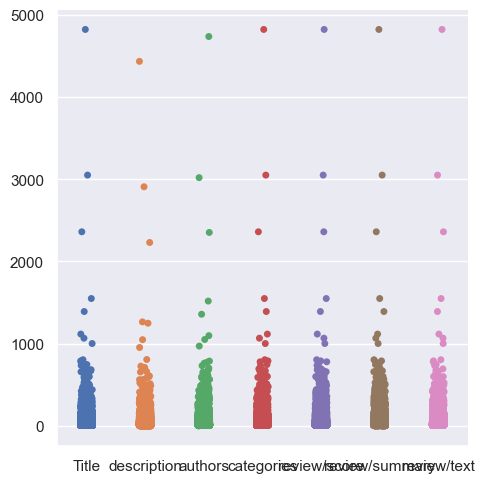

In [11]:
sns.catplot(merged_data_user_id_group_gt10)

### We see there are clear outliers as a few users have given too many ratings. These users are outliers and they may skew the recommendations. Based on the graph above, we will use a cutoff of 800 reviews, meaning we will leave the users who have given more than 1300 reviews

In [12]:
merged_data_user_id_cut_off = merged_data_user_id_group_gt10[merged_data_user_id_group_gt10.Title < 800]

In [13]:
merged_data_user_id_cut_off.describe()

,Title,description,authors,categories,review/score,review/summary,review/text
count,21169.000000,21169.000000,21169.000000,21169.000000,21169.000000,21169.000000,21169.000000
mean,26.516227,24.365298,26.120365,26.516227,26.516227,26.494166,26.516227
std,40.678795,36.954065,39.925259,40.678795,40.678795,40.680440,40.678795
min,10.000000,0.000000,0.000000,10.000000,10.000000,0.000000,10.000000
25%,12.000000,11.000000,12.000000,12.000000,12.000000,12.000000,12.000000
50%,15.000000,14.000000,15.000000,15.000000,15.000000,15.000000,15.000000
75%,24.000000,22.000000,24.000000,24.000000,24.000000,24.000000,24.000000
max,791.000000,727.000000,774.000000,791.000000,791.000000,791.000000,791.000000


C:\Users\dikshashukla\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


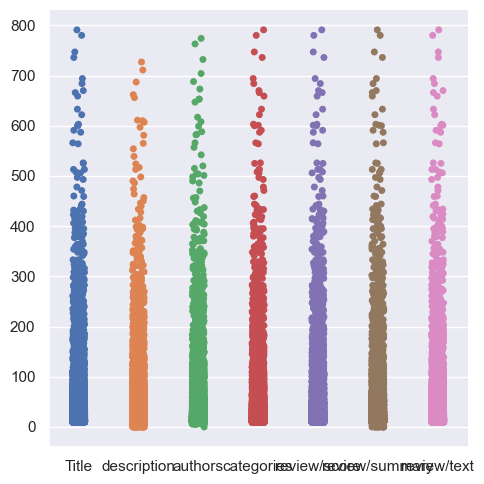

In [14]:
sns.catplot(merged_data_user_id_cut_off)

### We now have a more continuous distribution meaning no outlying behavior

### Let's keep only relevant rows in the main dataset. That is we will only keep the rows corresponding to the users in the merged_data_user_id_cut_off dataset

In [15]:
merged_data_valid_user_id = merged_data_valid_user_id[merged_data_valid_user_id.User_id.isin(merged_data_user_id_cut_off.index)]

In [16]:
merged_data_valid_user_id.shape

(561322, 8)

In [17]:
merged_data_valid_user_id.head(5)

,Title,description,authors,categories,User_id,review/score,review/summary,review/text
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A30TK6U7DNS82R,5.0,really enjoyed it,i dont care much for dr seuss but after readin...
3,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A2MVUWT453QH61,4.0,phlip nel gives silly seuss a serious treatment,theodore seuss geisel 19041991 aka quotdr seus...
5,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A2F6NONFUDB6UK,4.0,one of americas greatest creative talents,dr seuss american icon by philip nel is a thou...
11,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,David R. Ray,['Religion'],A373VVEU6Z9M0N,5.0,small churches can have wonderful worship,many small churches feel like they can not hav...
54,Rising Sons and Daughters: Life Among Japan's ...,Wardell recalls his experience as a foreign st...,Steven Wardell,['Social Science'],A3NIQK6ZLYEP1L,4.0,almost a day by day view,steven wardell went to japan without reading a...


### Let's look at the name of unique titles

In [36]:
merged_data_valid_user_id.isna().sum()

Title                 0
description       45533
authors            8380
categories            0
User_id               0
review/score          0
review/summary      467
review/text           0
dtype: int64

### Let's remove all the rows with no description as we will not have the information to assess the book type

In [38]:
merged_data_valid_user_id = merged_data_valid_user_id[~merged_data_valid_user_id.description.isna()]
merged_data_valid_user_id.shape

(515789, 8)

### We have strings in our dataset for Title and User_id but we need to convert them into int for implementing collaborative filtering. We will create new  columns with ids by using pd.factorize.

In [49]:
merged_data_valid_user_id.loc[:,'UserId'] = pd.factorize(merged_data_valid_user_id.User_id)[0]
merged_data_valid_user_id.loc[:,'BookId'] = pd.factorize(merged_data_valid_user_id.Title)[0]

In [50]:
merged_data_valid_user_id.rename(columns={'review/score':'Ratings'}, inplace=True)

In [51]:
merged_data_valid_user_id.head(5)

,Title,description,authors,categories,User_id,Ratings,review/summary,review/text,UserId,BookId
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A30TK6U7DNS82R,5.0,really enjoyed it,i dont care much for dr seuss but after readin...,0,0
3,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A2MVUWT453QH61,4.0,phlip nel gives silly seuss a serious treatment,theodore seuss geisel 19041991 aka quotdr seus...,1,0
5,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A2F6NONFUDB6UK,4.0,one of americas greatest creative talents,dr seuss american icon by philip nel is a thou...,2,0
11,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,David R. Ray,['Religion'],A373VVEU6Z9M0N,5.0,small churches can have wonderful worship,many small churches feel like they can not hav...,3,1
54,Rising Sons and Daughters: Life Among Japan's ...,Wardell recalls his experience as a foreign st...,Steven Wardell,['Social Science'],A3NIQK6ZLYEP1L,4.0,almost a day by day view,steven wardell went to japan without reading a...,4,2


### Let's look whether our ids our actually unique by sorting the datasets on them

In [52]:
book_review_uers_sort = merged_data_valid_user_id.sort_values(by="UserId")

In [53]:
book_review_uers_sort.head(10)

,Title,description,authors,categories,User_id,Ratings,review/summary,review/text,UserId,BookId
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A30TK6U7DNS82R,5.0,really enjoyed it,i dont care much for dr seuss but after readin...,0,0
2152339,The Season: Inside Palm Beach and America's Ri...,Palm Beach is known around the world as the mo...,Ronald Kessler,['Social Science'],A30TK6U7DNS82R,2.0,i hate myself,i hate myself for having read this book right ...,0,59998
977344,Destination Unknown,In Agatha Christie’s gripping international th...,Agatha Christie,['Fiction'],A30TK6U7DNS82R,5.0,the creeping unknown,i know this book has an indifferent reputation...,0,23200
1505098,Girls for Breakfast,"All children have a sweet tooth, but this litt...",J. L. Humphreys,['Juvenile Fiction'],A30TK6U7DNS82R,4.0,breakfast of champions,david yoos novel feels a little overextended d...,0,38904
1510153,Planting Eli (Southern Tier Editions),"Ed Dell is gay, single and confidante to godde...",Jeff Black,['Fiction'],A30TK6U7DNS82R,4.0,all the world loves a clown,even if youre not 100 per cent crazy about thi...,0,38984
1512136,The Curved Planks: Poems / A Bilingual Edition...,For decades readers and critics have acclaimed...,Yves Bonnefoy,['Poetry'],A30TK6U7DNS82R,5.0,ne cesse pas voix proche,its a terrific idea to publish a bilingual edi...,0,39072
971000,Ariel,"“Part post-apocalypse, part road-trip, part sw...",Steven R. Boyett,['Fiction'],A30TK6U7DNS82R,5.0,love set you going she wrote like a fat gold w...,now at long last we get the ariel we deserve p...,0,23020
965587,Blood Brother: 33 Reasons My Brother Scott Pet...,Scott Peterson's sister describes her relation...,Anne Bird,"['Biography', 'Autobiography']",A30TK6U7DNS82R,4.0,blood brother made for headlines,you have to choke down a feeling of disgust to...,0,22874
156584,Everything Was Possible: The Birth of the Musi...,"(Applause Books). In 1971, college student Ted...",Ted Chapin,['Performing Arts'],A30TK6U7DNS82R,5.0,ted and yvonne,the book is good but it is the book of two men...,0,2837
964544,Too Far,Blaze a trail with two wayward kids as they ex...,Rich Shapero,['Fiction'],A30TK6U7DNS82R,4.0,anal rule in high school,in too far veteran sportswriter mike lupica ha...,0,22846


### Let's get rid of any duplicate userid and book id combination

In [54]:
book_review_uers_sort_wdupl = book_review_uers_sort[~book_review_uers_sort.duplicated(subset = ['UserId', 'BookId'])]

In [55]:
book_review_uers_sort_wdupl.shape

(411162, 10)

### Our main goal is to recommend books based on user's personality types. The steps we will follow to do that:
- Categorize books on different personality types using description and categories
- Do collaborative filtering to generate embeddings or latent factors to club similar books
- Ask user to enter a short bio that will be used to detect personality types. 

In [68]:
book_review_uers_sort_unique_books = book_review_uers_sort_wdupl[~book_review_uers_sort_wdupl.duplicated(subset = ['BookId'])]

In [69]:
book_review_uers_sort_unique_books.loc[:,"AllText"] = book_review_uers_sort_unique_books["description"] + book_review_uers_sort_unique_books["categories"]

C:\Users\dikshashukla\AppData\Local\Temp\ipykernel_82648\1399298352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_review_uers_sort_unique_books.loc[:,"AllText"] = book_review_uers_sort_unique_books["description"] + book_review_uers_sort_unique_books["categories"]


In [87]:
book_review_uers_sort_unique_books = book_review_uers_sort_unique_books[["BookId", "AllText"]].sort_values(by="BookId").reset_index(drop=True)

In [88]:
book_review_uers_sort_unique_books.head(10)

,BookId,AllText
0,0,Philip Nel takes a fascinating look into the k...
1,1,This resource includes twelve principles in un...
2,2,Wardell recalls his experience as a foreign st...
3,3,Counters the Western views and stereotypes of ...
4,4,Dramatica for Screenwriters by Armando Saldana...
5,5,"Herb Caen, a popular columnist for the San Fra..."
6,6,The DK Eyewitness Travel Guide: Eastern and Ce...
7,7,"See the history of witchcraft, magic and super..."
8,8,"Twenty-five years ago, at the height of the co..."
9,9,The Bismarck is perhaps the most famous – and ...


In [72]:
from transformers import BertTokenizer, BertForSequenceClassification

def personality_detection(text):
    tokenizer = BertTokenizer.from_pretrained("Minej/bert-base-personality")
    model = BertForSequenceClassification.from_pretrained("Minej/bert-base-personality")

    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    outputs = model(**inputs)
    predictions = outputs.logits.squeeze().detach().numpy()

    label_names = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
    result = {label_names[i]: predictions[i] for i in range(len(label_names))}

    return result

In [91]:
personality_detection(book_review_uers_sort_unique_books.Personality_Values)

AttributeError: 'DataFrame' object has no attribute 'Personality_Values'

In [90]:
book_review_uers_sort_unique_books.loc[:,"Personality_Values"] =book_review_uers_sort_unique_books.AllText.apply(lambda x:personality_detection(x))

KeyboardInterrupt: 

In [ ]:
#merged_data_valid_user_id.to_csv("../data/interim/merged_data_ids.csv", index=False)

### Now we split the data in train and test

In [ ]:
from sklearn.model_selection import train_test_split
X = merged_data_valid_user_id[['UserId', 'BookId']]
y = merged_data_valid_user_id['Ratings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 0)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

### We have our train and test data sets ready. In the next stage, we will build collaborative filtering model using PyTorch